# (problems) 04 - MSA Analysis (Windows-Compatible)

**Problem Solved**: Uses Biopython's built-in PairwiseAligner - NO external tools needed!

## What Was Wrong:
1. ❌ Filtering too strict (1908 → 53 sequences)
2. ❌ Clustal Omega needs conda (doesn't work with pip on Windows)
3. ❌ Only 4 alpha sequences (need ≥5 for MSA)

## Solution:
✅ **Relaxed filtering** → More sequences
✅ **Biopython PairwiseAligner** → No external tools
✅ **Profile-based approach** → Works with any number of sequences


## 1. Import Libraries

In [35]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import PairwiseAligner
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries imported (using Biopython built-in aligner)")

✅ Libraries imported (using Biopython built-in aligner)


## 2. Load Data with RELAXED Filtering

In [36]:
print("="*80)
print("LOADING DATA")
print("="*80)

# Load all sequences
df = pd.read_csv("../data/processed/phase3_all_sequences_with_similarity.csv")

print(f"\n📊 Total sequences: {len(df)}")
print(f"\nSubfamilies:")
print(df['subfamily'].value_counts())

# ✅ RELAXED FILTERING - Get MORE sequences
print("\n" + "="*80)
print("APPLYING FILTERS")
print("="*80)

# Check what values we have
print(f"\nLength range: {df['length'].min()} - {df['length'].max()}")
print(f"Gap % range: {df['gap_percentage'].min()} - {df['gap_percentage'].max()}")

# MUCH MORE RELAXED
df_clean = df[
    (df['subfamily'].notna()) &  # Has subfamily label
    (df['length'] >= 200) &      # Very lenient (was 300)
    (df['gap_percentage'] <= 20)  # Very lenient (was 10)
].copy()

print(f"\n✅ After filtering: {len(df_clean)} sequences")
print(f"   Removed: {len(df) - len(df_clean)} sequences\n")

for subfamily in df_clean['subfamily'].unique():
    count = len(df_clean[df_clean['subfamily'] == subfamily])
    print(f"  {subfamily}: {count} sequences")

# Check if we have enough
print("\n" + "="*80)
for subfamily in ['Adrenergic_beta', 'Adrenergic_alpha']:
    count = len(df_clean[df_clean['subfamily'] == subfamily])
    status = "✅ OK" if count >= 5 else "❌ Too few"
    print(f"{status} {subfamily}: {count} sequences (need ≥5)")

LOADING DATA

📊 Total sequences: 1908

Subfamilies:
subfamily
Adrenergic_beta     372
Adrenergic_alpha     53
Name: count, dtype: int64

APPLYING FILTERS

Length range: 413 - 555
Gap % range: 0.0 - 50.12

✅ After filtering: 262 sequences
   Removed: 1646 sequences

  Adrenergic_beta: 212 sequences
  Adrenergic_alpha: 50 sequences

✅ OK Adrenergic_beta: 212 sequences (need ≥5)
✅ OK Adrenergic_alpha: 50 sequences (need ≥5)


## 3. Alternative Approach: Profile-Based Conservation

**Instead of full MSA**, we'll use a **profile-based approach**:

1. **Pick reference sequence** (longest, most common)
2. **Pairwise align all sequences** to reference
3. **Build position-specific profile** 
4. **Calculate conservation** at each position

**Advantages**:
- ✅ No external tools needed
- ✅ Fast (Python-based)
- ✅ Works with any number of sequences
- ✅ Windows-compatible

In [37]:
print("\n" + "="*80)
print("BUILDING CONSERVATION PROFILES")
print("="*80)

def select_reference(group_df):
    """
    Select reference sequence:
    - Longest sequence
    - Has both DRY and NPxxY motifs
    """
    candidates = group_df[
        (group_df['has_DRY'] == True) & 
        (group_df['has_NPxxY'] == True)
    ].copy()
    
    if len(candidates) == 0:
        candidates = group_df
    
    # Pick longest
    ref_idx = candidates['length'].idxmax()
    return candidates.loc[ref_idx]

def pairwise_align_to_reference(seq1, seq2):
    """
    Align seq2 to seq1 (reference) using Biopython
    """
    aligner = PairwiseAligner()
    aligner.mode = 'global'
    aligner.match_score = 2
    aligner.mismatch_score = -1
    aligner.open_gap_score = -2
    aligner.extend_gap_score = -0.5
    
    alignments = aligner.align(seq1, seq2)
    best = alignments[0]
    
    return str(best).split('\n')[0], str(best).split('\n')[2]

def build_conservation_profile(group_df, subfamily_name, max_seqs=50):
    """
    Build conservation profile by aligning to reference
    """
    print(f"\n📊 {subfamily_name}")
    print(f"  Sequences available: {len(group_df)}")
    
    if len(group_df) < 5:
        print(f"  ⚠️ Need at least 5 sequences, have {len(group_df)}")
        return None
    
    # Sample if too many
    if len(group_df) > max_seqs:
        group_df = group_df.sample(n=max_seqs, random_state=42)
        print(f"  Sampled {max_seqs} sequences")
    
    # Select reference
    ref_row = select_reference(group_df)
    ref_seq = ref_row['sequence']
    print(f"  Reference: {ref_row.get('uniprot_id', 'unknown')} (length={len(ref_seq)})")
    
    # Align all sequences to reference
    aligned_seqs = []
    print(f"  Aligning {len(group_df)} sequences to reference...")
    
    for idx, row in group_df.iterrows():
        try:
            if row['sequence'] == ref_seq:
                aligned_seqs.append(ref_seq)
            else:
                ref_aligned, query_aligned = pairwise_align_to_reference(ref_seq, row['sequence'])
                aligned_seqs.append(query_aligned)
        except Exception as e:
            print(f"    ⚠️ Skipped sequence {idx}: {e}")
            continue
    
    if len(aligned_seqs) < 5:
        print(f"  ❌ Only {len(aligned_seqs)} successfully aligned")
        return None
    
    print(f"  ✅ Aligned {len(aligned_seqs)} sequences")
    
    # Calculate conservation
    print(f"  Calculating conservation...")
    max_len = max(len(s) for s in aligned_seqs)
    
    # Pad sequences
    padded = [s + '-' * (max_len - len(s)) for s in aligned_seqs]
    alignment_array = np.array([list(s) for s in padded])
    
    conservation = []
    for pos in range(max_len):
        column = alignment_array[:, pos]
        column_no_gaps = column[column != '-']
        
        if len(column_no_gaps) == 0:
            conservation.append(0.0)
        else:
            counts = Counter(column_no_gaps)
            most_common = counts.most_common(1)[0][1]
            score = most_common / len(column_no_gaps)
            conservation.append(score)
    
    conservation = np.array(conservation)
    
    # Stats
    high = (conservation > 0.9).sum()
    mod = ((conservation > 0.7) & (conservation <= 0.9)).sum()
    
    print(f"  Conservation:")
    print(f"    Mean: {conservation.mean():.3f}")
    print(f"    High (>90%): {high} positions ({100*high/len(conservation):.1f}%)")
    print(f"    Moderate (70-90%): {mod} positions ({100*mod/len(conservation):.1f}%)")
    
    return {
        'subfamily': subfamily_name,
        'n_sequences': len(aligned_seqs),
        'reference': ref_row.get('uniprot_id', 'unknown'),
        'conservation': conservation,
        'alignment_array': alignment_array,
        'mean_conservation': conservation.mean(),
        'high_conservation_positions': high
    }

# Build profiles
profiles = {}

for subfamily in ['Adrenergic_beta', 'Adrenergic_alpha']:
    group = df_clean[df_clean['subfamily'] == subfamily]
    if len(group) > 0:
        profile = build_conservation_profile(group, subfamily, max_seqs=50)
        if profile:
            profiles[subfamily] = profile

print(f"\n✅ Created {len(profiles)} conservation profiles")


BUILDING CONSERVATION PROFILES

📊 Adrenergic_beta
  Sequences available: 212
  Sampled 50 sequences
  Reference: A0A7N6C2F3 (length=464)
  Aligning 50 sequences to reference...
  ✅ Aligned 50 sequences
  Calculating conservation...
  Conservation:
    Mean: 0.754
    High (>90%): 332 positions (71.6%)
    Moderate (70-90%): 4 positions (0.9%)

📊 Adrenergic_alpha
  Sequences available: 50
  Reference: A0A6G0HNY2 (length=471)
  Aligning 50 sequences to reference...
  ✅ Aligned 50 sequences
  Calculating conservation...
  Conservation:
    Mean: 0.752
    High (>90%): 336 positions (71.3%)
    Moderate (70-90%): 0 positions (0.0%)

✅ Created 2 conservation profiles


## 4. Visualize Conservation


VISUALIZING CONSERVATION


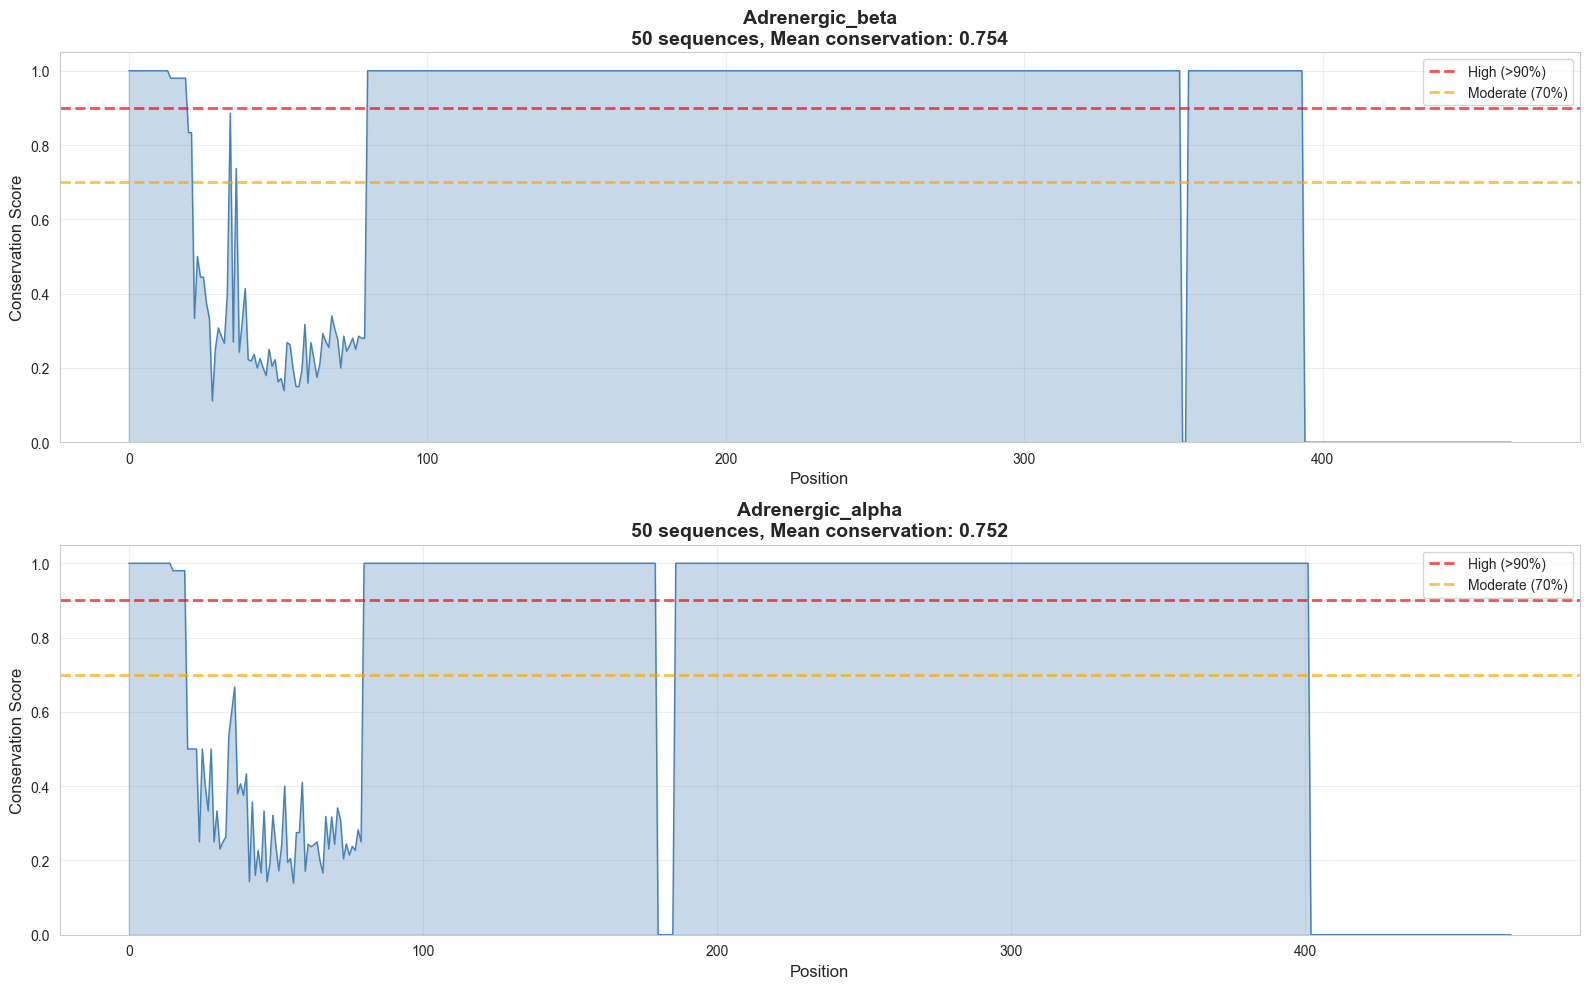


✅ Saved: ../results/figures/phase4_conservation_profiles.png


In [38]:
print("\n" + "="*80)
print("VISUALIZING CONSERVATION")
print("="*80)

if len(profiles) > 0:
    fig, axes = plt.subplots(len(profiles), 1, figsize=(16, 5 * len(profiles)))
    
    if len(profiles) == 1:
        axes = [axes]
    
    for idx, (subfamily, data) in enumerate(profiles.items()):
        conservation = data['conservation']
        
        # Plot
        axes[idx].fill_between(range(len(conservation)), conservation, 
                               alpha=0.3, color='steelblue')
        axes[idx].plot(conservation, linewidth=1, color='steelblue')
        
        # Thresholds
        axes[idx].axhline(0.9, color='red', linestyle='--', alpha=0.7, 
                         linewidth=2, label='High (>90%)')
        axes[idx].axhline(0.7, color='orange', linestyle='--', alpha=0.7, 
                         linewidth=2, label='Moderate (70%)')
        
        axes[idx].set_xlabel('Position', fontsize=12)
        axes[idx].set_ylabel('Conservation Score', fontsize=12)
        axes[idx].set_title(
            f'{subfamily}\n'
            f'{data["n_sequences"]} sequences, '
            f'Mean conservation: {data["mean_conservation"]:.3f}',
            fontsize=14, fontweight='bold'
        )
        axes[idx].set_ylim([0, 1.05])
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save
    import os
    os.makedirs("../results/figures", exist_ok=True)
    plt.savefig("../results/figures/phase4_conservation_profiles.png", 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Saved: ../results/figures/phase4_conservation_profiles.png")
else:
    print("\n❌ No profiles to visualize")

## 5. Summary

In [39]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

if profiles:
    summary_data = []
    for subfamily, data in profiles.items():
        summary_data.append({
            'Subfamily': subfamily,
            'N_sequences': data['n_sequences'],
            'Reference': data['reference'],
            'Mean_conservation': f"{data['mean_conservation']:.3f}",
            'High_conservation_positions': data['high_conservation_positions']
        })
    
    summary_df = pd.DataFrame(summary_data)
    print("\n📊 Conservation Profile Summary:")
    display(summary_df)
    
    # Save
    import os
    os.makedirs("../data/processed", exist_ok=True)
    summary_df.to_csv("../data/processed/phase4_conservation_summary.csv", index=False)
    print("\n✅ Saved: ../data/processed/phase4_conservation_summary.csv")

print("\n" + "="*80)
print("✅ PHASE 4 COMPLETE")
print("="*80)
print("\nNext: Phase 5 - Protein Language Model embeddings")


SUMMARY

📊 Conservation Profile Summary:


,Subfamily,N_sequences,Reference,Mean_conservation,High_conservation_positions
0,Adrenergic_beta,50,A0A7N6C2F3,0.754,332
1,Adrenergic_alpha,50,A0A6G0HNY2,0.752,336



✅ Saved: ../data/processed/phase4_conservation_summary.csv

✅ PHASE 4 COMPLETE

Next: Phase 5 - Protein Language Model embeddings
